In [ ]:
!pip install torchdiffeq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint  # Use the adjoint method
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
torch.manual_seed(42)

# Check for GPU availability and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Define the "True" System (The problem we want to learn) ---
# We'll use a damped harmonic oscillator:
# d^2x/dt^2 + b*dx/dt + k*x = 0
# As a 1st-order system (y = [x, dx/dt]):
# dy[0]/dt = y[1]
# dy[1]/dt = -k*y[0] - b*y[1]

class TrueDynamics(nn.Module):
    def __init__(self, k=3.0, b=0.5):
        super(TrueDynamics, self).__init__()
        self.k = torch.tensor([k]).to(device)
        self.b = torch.tensor([b]).to(device)

    def forward(self, t, y):
        # y is a tensor of shape [batch_size, 2]
        # y[..., 0] is position (x)
        # y[..., 1] is velocity (dx/dt)

        dydt = torch.zeros_like(y)
        dydt[..., 0] = y[..., 1]
        dydt[..., 1] = -self.k * y[..., 0] - self.b * y[..., 1]
        return dydt

# --- 2. Define the Neural ODE (The model we will train) ---
# This is a standard neural network that *must* have the same
# input/output signature as the ODE function: f(t, y) -> dy/dt

class NeuralODE(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2):
        super(NeuralODE, self).__init__()
        # Our network will learn the function f(y, t)
        # Note: We include time 't' as a feature, which is often helpful
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim),
        ).to(device) # Move the network to the specified device

    def forward(self, t, y):
        # We need to concatenate t and y
        # t has shape [1], y has shape [batch_size, 2]
        # We'll unsqueeze t to match the batch dimension
        t_vec = torch.ones(y.shape[0], 1).to(device) * t
        # Concatenate time and state
        t_and_y = torch.cat([t_vec, y], dim=1)
        return self.net(t_and_y)

# --- 3. Generate Training Data ---

# Create an instance of the true system
true_system = TrueDynamics()

# Set up simulation parameters
t_start = 0.
t_end = 10.
num_time_points = 100
batch_size = 32

# Define the time points to sample
# shape: [num_time_points]
t_points = torch.linspace(t_start, t_end, num_time_points).to(device)

# Define initial conditions (y0)
# shape: [batch_size, 2] (e.g., [position, velocity])
y0 = torch.tensor([[2.0, 0.0]]).to(device) # Start at position 2.0, velocity 0.0
# Replicate for a "batch"
y0_batch = y0.repeat(batch_size, 1)

# Generate the ground truth data by solving the true ODE
with torch.no_grad():
    # We use the standard 'odeint' here (not adjoint) as we don't need gradients
    from torchdiffeq import odeint as odeint_plain
    # shape: [num_time_points, batch_size, 2]
    y_true = odeint_plain(true_system, y0_batch, t_points)
    # Transpose to [batch_size, num_time_points, 2] for easier training
    y_true = y_true.permute(1, 0, 2)


# --- 4. The Training Loop ---

# Instantiate our model
learned_model = NeuralODE()
optimizer = optim.Adam(learned_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()


print("Starting training...")
for epoch in range(1000):
    # Get a batch of initial conditions and true trajectories
    # (In this simple case, we use the same batch repeatedly)

    # --- Forward pass ---
    # Solve the ODE defined by our 'learned_model'
    # This is where the magic happens!
    # 'odeint' uses the adjoint method to be memory-efficient
    # and to compute gradients for 'learned_model.parameters()'

    # shape: [num_time_points, batch_size, 2]
    y_pred = odeint(learned_model, y0_batch, t_points)
    # Transpose to [batch_size, num_time_points, 2]
    y_pred = y_pred.permute(1, 0, 2)

    # --- Compute Loss ---
    loss = loss_func(y_pred, y_true)


    # --- Backward pass and optimization ---
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:4d} | Loss: {loss.item():.6f}")

print("Training complete.")

Using device: cuda:0
Starting training...
Epoch  100 | Loss: 0.705546
Epoch  200 | Loss: 0.507816
Epoch  300 | Loss: 0.031520
Epoch  400 | Loss: 0.006912
Epoch  500 | Loss: 0.003194
Epoch  600 | Loss: 0.002178
Epoch  700 | Loss: 0.001671
Epoch  800 | Loss: 0.001315
Epoch  900 | Loss: 0.001041
Epoch 1000 | Loss: 0.000831
Training complete.


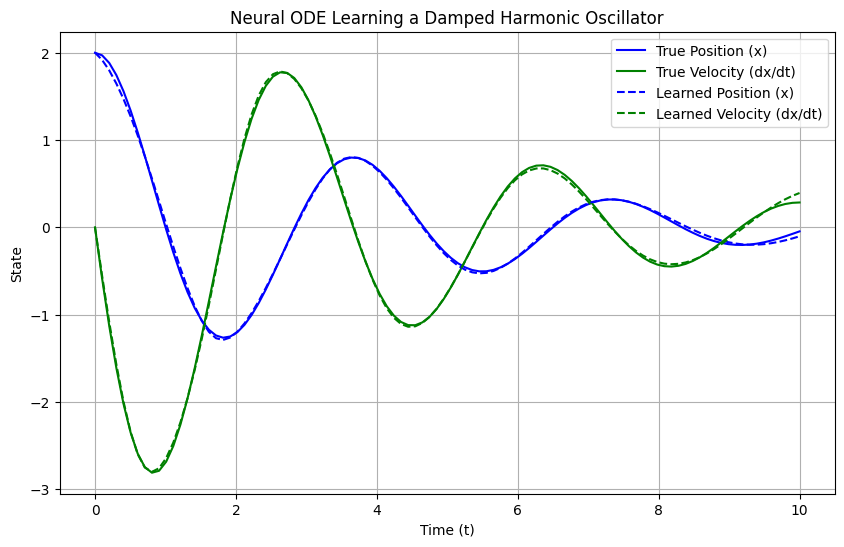

In [ ]:
# --- 5. Visualize the Results ---

# Generate a final trajectory from the trained model
with torch.no_grad():
    # Use a single initial condition for a clean plot
    y0_plot = torch.tensor([[2.0, 0.0]]).to(device)

    # Get true trajectory
    true_traj = odeint_plain(true_system, y0_plot, t_points).squeeze()

    # Get learned trajectory
    # We use the 'odeint' (adjoint) here just to be consistent,
    # but plain would work too since gradients are off.
    learned_traj = odeint(learned_model, y0_plot, t_points).squeeze()

# Plot the results
t_points_np = t_points.cpu().numpy()
true_traj_np = true_traj.cpu().numpy()
learned_traj_np = learned_traj.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(t_points_np, true_traj_np[:, 0], 'b-', label='True Position (x)')
plt.plot(t_points_np, true_traj_np[:, 1], 'g-', label='True Velocity (dx/dt)')
plt.plot(t_points_np, learned_traj_np[:, 0], 'b--', label='Learned Position (x)')
plt.plot(t_points_np, learned_traj_np[:, 1], 'g--', label='Learned Velocity (dx/dt)')
plt.title('Neural ODE Learning a Damped Harmonic Oscillator')
plt.xlabel('Time (t)')
plt.ylabel('State')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Save the Trained Model ---

# Define a path to save the model
model_save_path = "neural_ode_model_example1.pth"

# Save the state dictionary of the learned_model
torch.save(learned_model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to neural_ode_model_example1.pth


Model loaded successfully from neural_ode_model_example1.pth


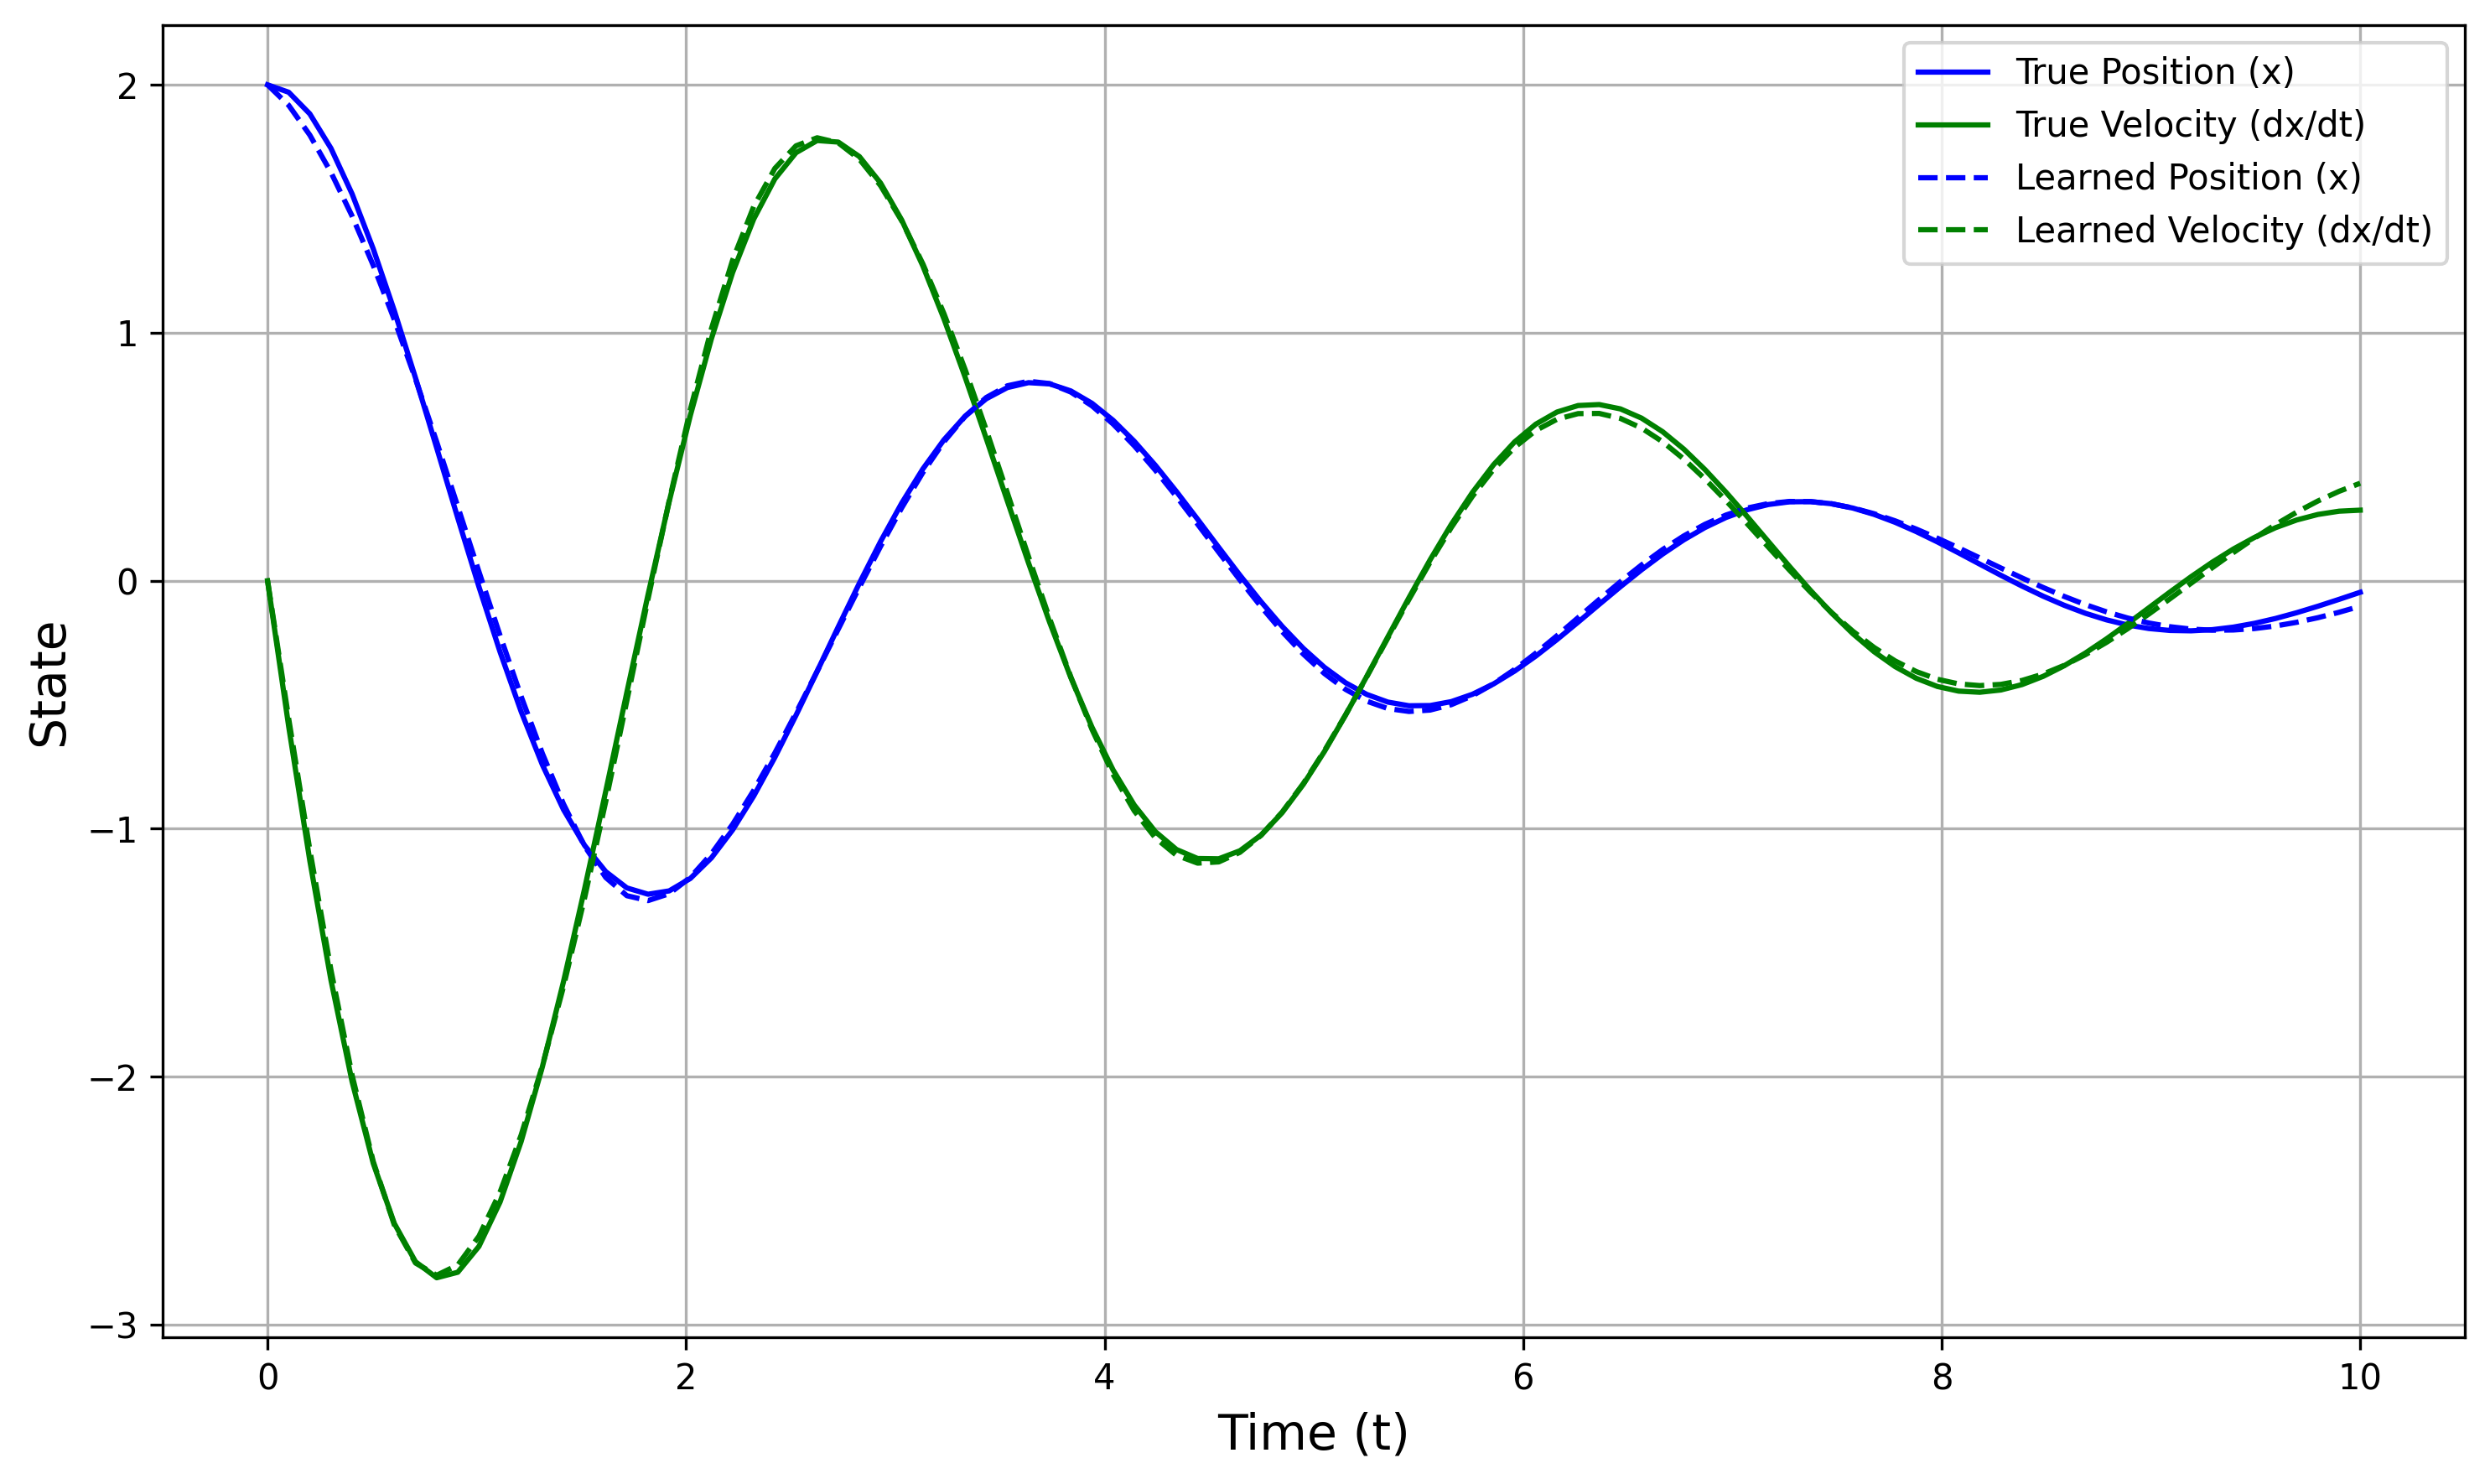

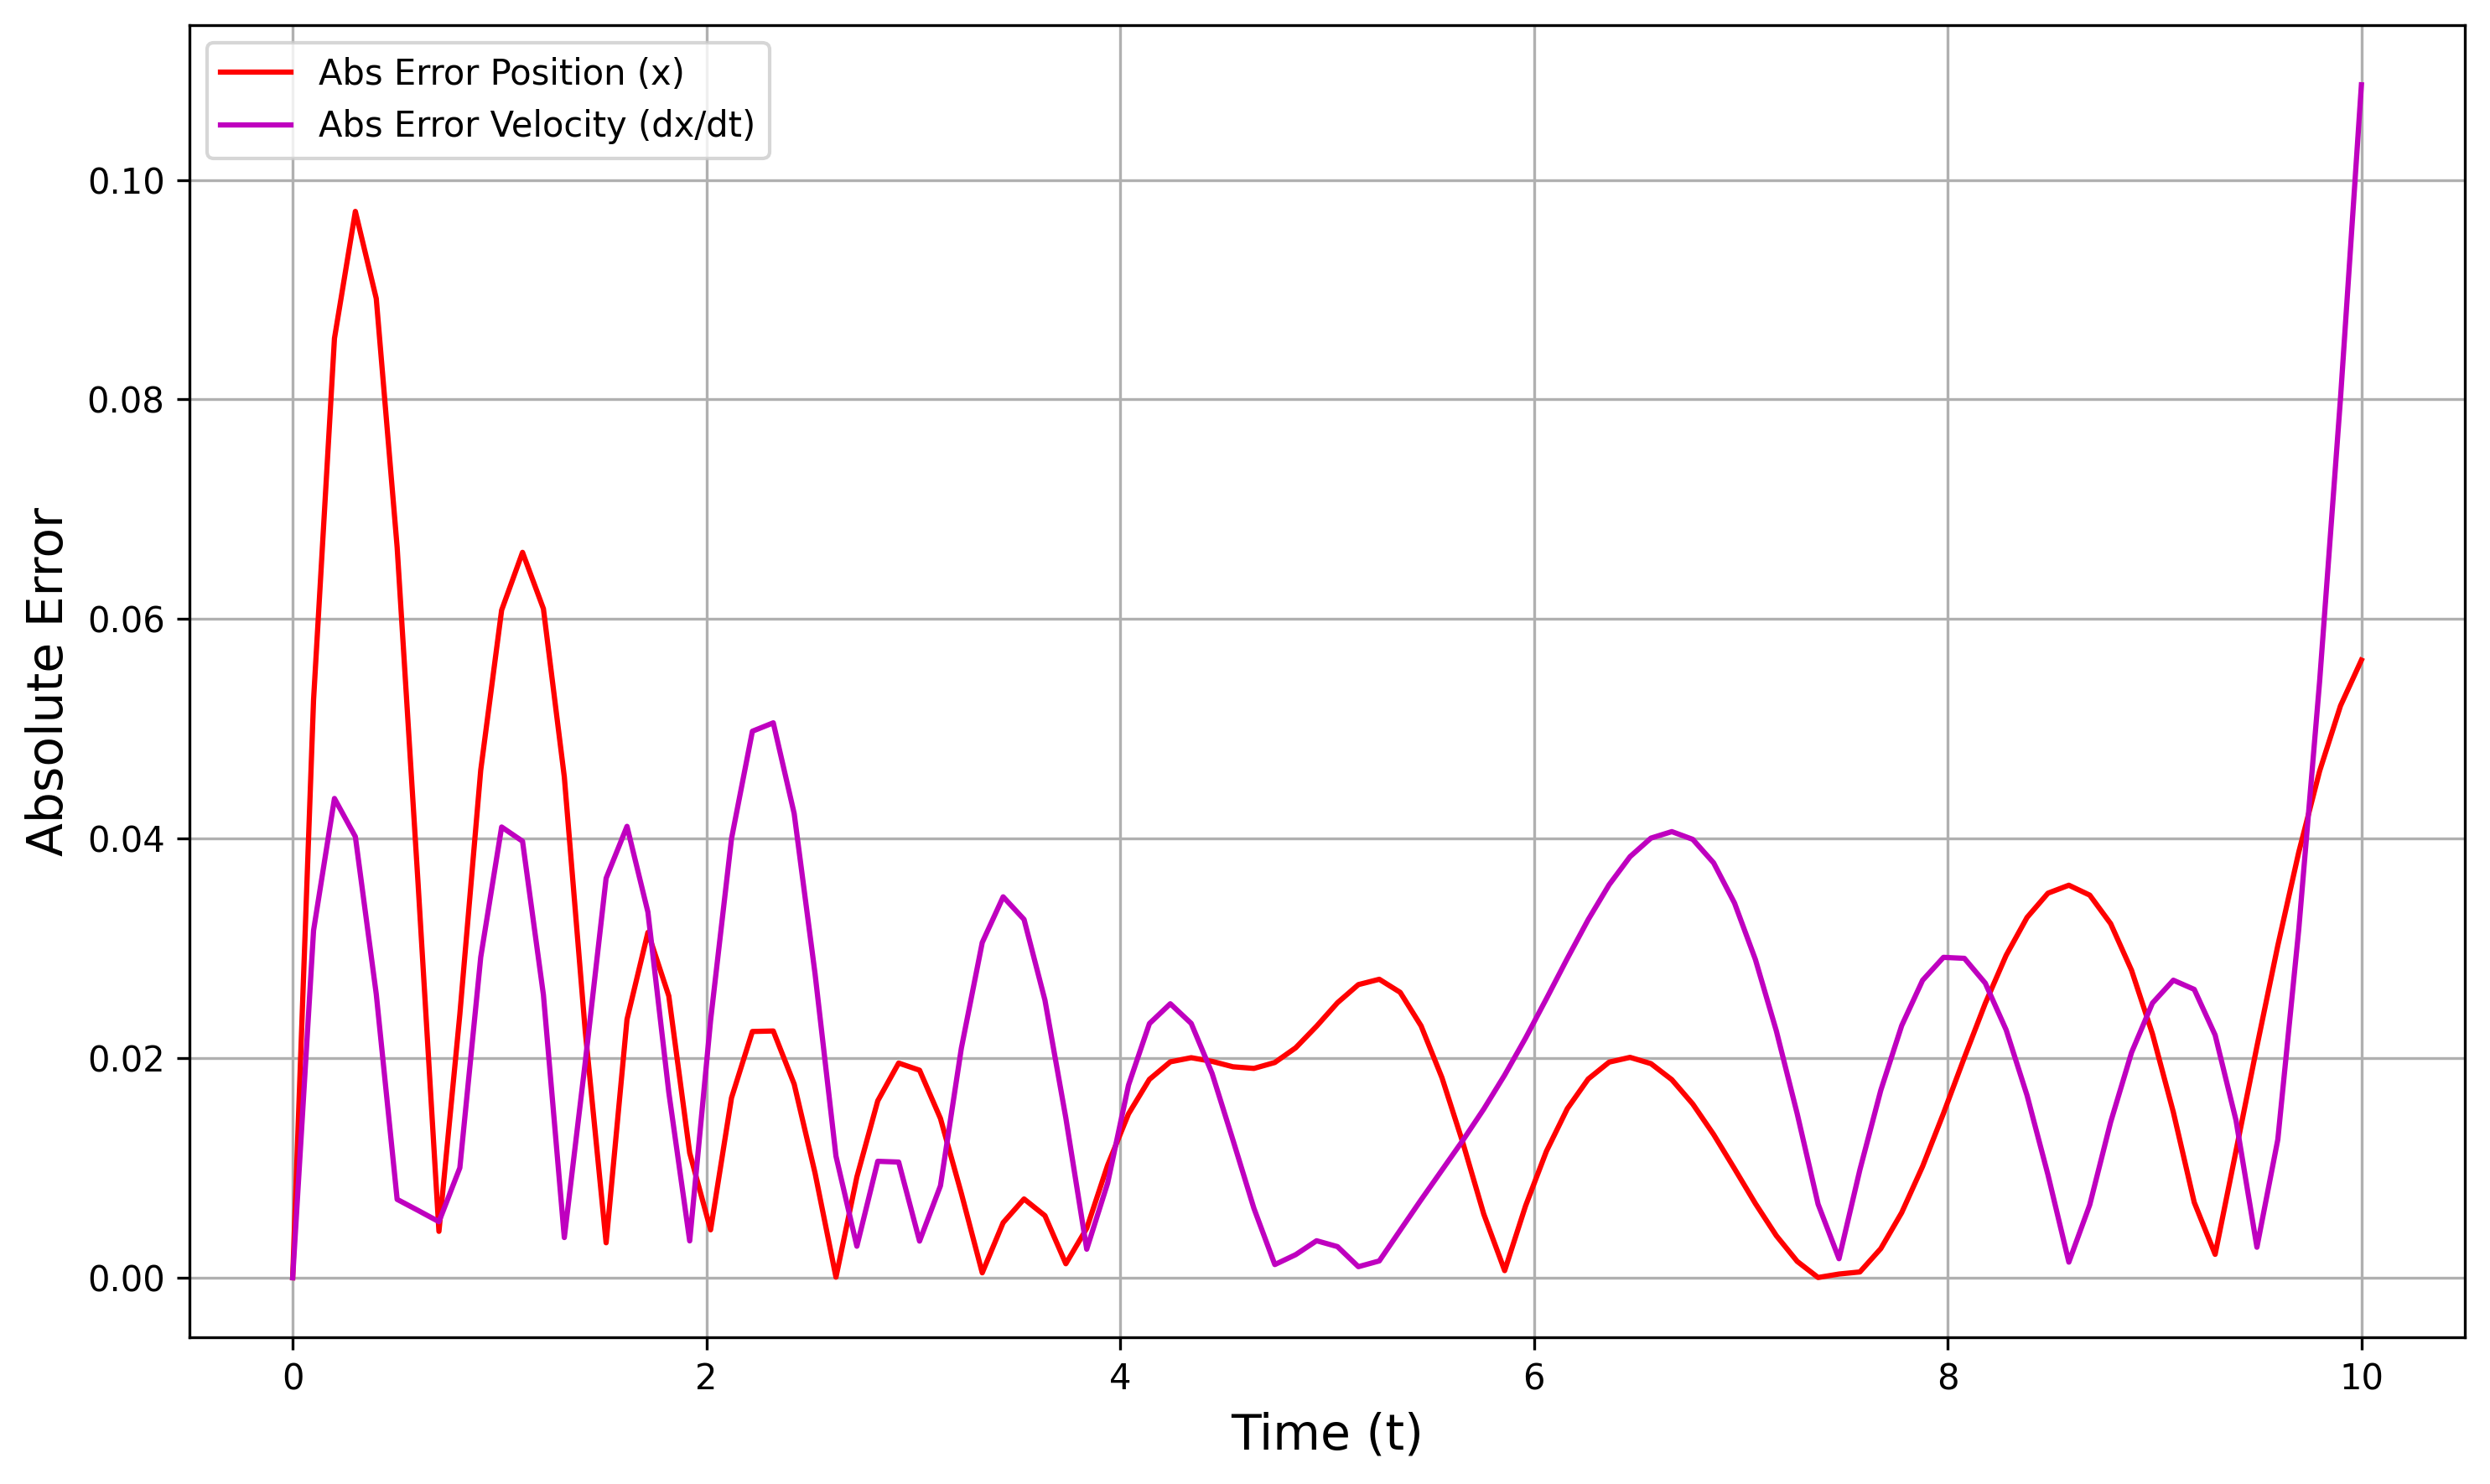

In [ ]:
import matplotlib.pyplot as plt

# --- Load the Trained Model and Visualize ---

# Instantiate a new NeuralODE model
loaded_model = NeuralODE()

# Define the path to the saved model
model_load_path = "neural_ode_model_example1.pth"

# Load the saved state dictionary
try:
    loaded_model.load_state_dict(torch.load(model_load_path, map_location=device))
    print(f"Model loaded successfully from {model_load_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_load_path}. Please run the training cell first.")
    loaded_model = None # Set to None if loading fails

if loaded_model is not None:
    loaded_model.to(device) # Ensure the loaded model is on the correct device
    loaded_model.eval() # Set the model to evaluation mode

    # Use the loaded_model for visualization
    with torch.no_grad():
        # Use a single initial condition for a clean plot
        y0_plot = torch.tensor([[2.0, 0.0]]).to(device)

        # Get true trajectory (still need this if you want to plot against ground truth)
        true_system = TrueDynamics() # Re-instantiate if needed, or ensure it's in scope
        true_traj = odeint_plain(true_system, y0_plot, t_points).squeeze() # Assuming t_points and odeint_plain are available

        # Get learned trajectory from the loaded model
        learned_traj = odeint(loaded_model, y0_plot, t_points).squeeze()

    # Plot the results
    t_points_np = t_points.cpu().numpy() # Assuming t_points is available
    true_traj_np = true_traj.cpu().numpy()
    learned_traj_np = learned_traj.cpu().numpy()

    # Calculate pointwise absolute error
    absolute_error_pos = torch.abs(true_traj[:, 0] - learned_traj[:, 0]).cpu().numpy()
    absolute_error_vel = torch.abs(true_traj[:, 1] - learned_traj[:, 1]).cpu().numpy()

    # Figure 1: True vs. Learned Trajectories
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(t_points_np, true_traj_np[:, 0], 'b-', label='True Position (x)')
    plt.plot(t_points_np, true_traj_np[:, 1], 'g-', label='True Velocity (dx/dt)')
    plt.plot(t_points_np, learned_traj_np[:, 0], 'b--', label='Learned Position (x)')
    plt.plot(t_points_np, learned_traj_np[:, 1], 'g--', label='Learned Velocity (dx/dt)')
    #plt.title('Neural ODE Learning a Damped Harmonic Oscillator', fontsize=14)
    plt.xlabel('Time (t)', fontsize=14)
    plt.ylabel('State', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Figure 2: Pointwise Absolute Error
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(t_points_np, absolute_error_pos, 'r-', label='Abs Error Position (x)')
    plt.plot(t_points_np, absolute_error_vel, 'm-', label='Abs Error Velocity (dx/dt)')
    #plt.title('Pointwise Absolute Error of Learned Trajectory', fontsize=14)
    plt.xlabel('Time (t)', fontsize=14)
    plt.ylabel('Absolute Error', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
